# Locality sensitive hashing using MinHash

The idea behind locality sensitive hashing is to take the document fingerprints and chop them up into pieces, each piece being some number of `minhash`es. Since a single `minhash` (single entry in the fingerprint) has a probability equal to the Jaccard similarity of producing a collision, each chopped up portion of the fingerprint should as well. This chopped up portion is the `locality` in locality sensitive hashing, the `hashing` is just a hash function (any hash function) which produces a `bin ID` from the fingerprint `locality` being hashed. Each bin holds the entire fingerprint (with optional meta information) of the document and that of other documents that hash to the same `bin`.

Let's say our fingerprint has 100 `minhash`es in it and we chop the fingerprints into 10 pieces. Each piece of each fingerprint therefore contains 10 `minhash`es, we hash those again (not using `minhash` this time) to get a `bin ID` and store the whole fingerprint in every bin each of the pieces happens to land in.

When we want to know which documents are similar to a query document, we look in all the bins the query document lands in, any document in any of the bins is a potential duplicate. Comparing the full fingerprint of all documents in the bin or computing the actual Jaccard similarity between the shingle sets yields the final similarity of documents. Crucially _since not all documents will land in the same bins we've reduced the number of comparisons needed to find similar or near duplicate documents_.

The number of pieces to chop each fingerprint into and the size of each piece are parameters that need to be set. These should be set such that $num\_pieces \times size\_of\_piece == num\_minhashes$ - this makes sense since having computed all the $N$ `minhash`es we want to use all of them in the locality sensitive hashing part. There is however a further issue that needs to be considered when setting the parameters; the relation between the number and size of the pieces and the probability of LSH "finding" a pair of similar documents.

LSH is a probabilistic model which means that it won't always do the "right thing". Using LSH one needs to consider the similarity of a pair of documents (in this case the Jaccard similarity) and the probability that LSH will find that pair to be similar (a true positive, i.e. a correctly discovered duplicate pair). The pair of documents LSH finds to be similar should be thought of as _candidate_ duplicates. The higher the probability, or guarantee, that LSH will find a pair of documents to be similar the more false positives the model will also produce, that is candidate duplicates that are not in fact duplicates.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math

ix = pd.IndexSlice

## How setting LSH parameters affects finding similar documents

Create a pandas dataframe with different configurations for b and r values. The different sizes are as follows: (2, 50), (50, 2), (10, 10), (5, 20), (20, 5).

In [2]:
df = pd.DataFrame(data=[(2, 50), (50, 2), (10, 10), (5, 20), (20, 5)], columns=['bands', 'row'])
print(df)

   bands  row
0      2   50
1     50    2
2     10   10
3      5   20
4     20    5


For every b and r compute the probability values using the equation discussed in class i.e, $p = 1 - (1 - t^b)^r$. Vary the threshold value from 0 to 1 with around 200 intervals.

In [3]:
df['hashes'] = df['bands'] * df['row']
for p in np.linspace(0, 1, 200):
    df[p] = 1 - (1 - p**df['bands']) ** df['row']

Create a pandas pivot table with the columns hashes, bands, row.

In [4]:
df = pd.pivot_table(df, index=['hashes', 'bands', 'row'])
print(df)

                  0.000000      0.005025      0.010050      0.015075  \
hashes bands row                                                       
100    2     50        0.0  1.261814e-03  5.037900e-03  1.130031e-02   
       5     20        0.0  6.408651e-11  2.050760e-09  1.557295e-08   
       10    10        0.0  0.000000e+00  0.000000e+00  0.000000e+00   
       20    5         0.0  0.000000e+00  0.000000e+00  0.000000e+00   
       50    2         0.0  0.000000e+00  0.000000e+00  0.000000e+00   

                      0.020101      0.025126      0.030151      0.035176  \
hashes bands row                                                           
100    2     50   2.000283e-02  3.108155e-02  4.445562e-02  6.002823e-02   
       5     20   6.562428e-08  2.002694e-07  4.983343e-07  1.077096e-06   
       10    10   0.000000e+00  1.110223e-15  6.661338e-15  2.886580e-14   
       20    5    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       50    2    0.000000e+00  0.00000

Initialize a plot with figsize of (10, 7) and title "Probability of LSH of finding a candidate pair"

Set ylabel to be "p" and xlabel to be "Jaccard Similarity". Now display the plot with the different values. 

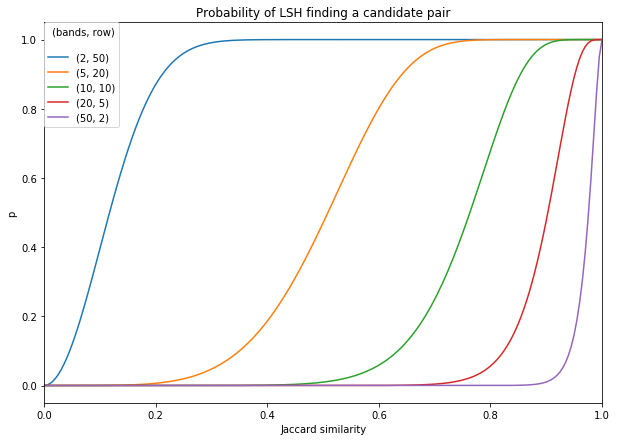

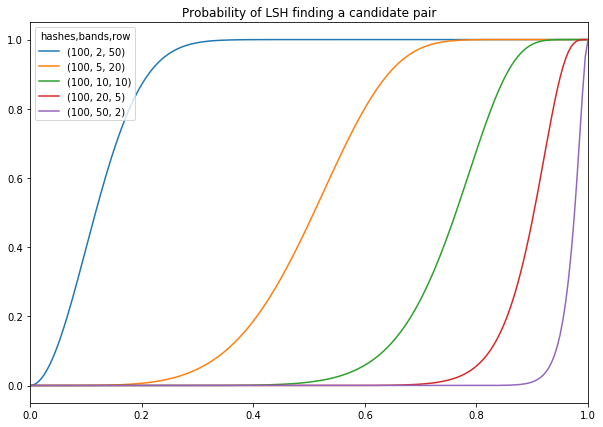

In [5]:
x = df.T.plot(figsize=(10, 7), title='Probability of LSH finding a candidate pair');
plt.ylabel('p');
plt.xlabel('Jaccard similarity');
plt.legend(list(df.loc[ix[100]].index),
           ncol=1, borderaxespad=0., title=' (bands, row)\n');x = df.T.plot(figsize=(10, 7), title='Probability of LSH finding a candidate pair');


## Computing LSH

Now import the MinHash function from your last assignment to get the MinHashSim matrix. You may re-insert the entire function too here.

In [6]:
import os
import re
import random
import time
import binascii

# Set the number of rows (or components) in the MinHash signatures. Will also need this
# many hash functions.
numHashRows = 10;

numDocs = 1000 # Start with 100. Meaning there are 100 articles in 1 data file (same as 100 individual docs).
dataFile = "./data/docs_" + str(numDocs) + ".train"
plagFile = "./data/docs_" + str(numDocs) + ".plag"

plagiarisms = {}

# Open the plag file.
f = open(plagFile, "rU")


# For each pair reported
for line in f:
    
  
  # Remove new-line character if present
    if line[-1] == '\n':
        line = line[0:-1]
      
    docs = line.split(" ")

    # Keep a map of the two documents
    plagiarisms[docs[0]] = docs[1]
    plagiarisms[docs[1]] = docs[0]

# Now convert the documents to shingles

print ("Creating Shingles...")

# Keep a current ID for the current shingle. When a new shingle is encountered in
# the dictionary, we will update this.

currentShingleID = 0

# Create a dictionary for the articles having a mapping of the article identifier
# for example t123, to the list of the shingle IDs.

documentShingleSets = {};
  
# Open the data file.
f = open(dataFile, "rU")

documentNames = []

numShingles = 0

for i in range(0, numDocs):
    
 
    # Read all the words (may need splitting)
    words = f.readline().split(" ")
  
    # Maintain a list of document IDs (article IDs)
    docID = words[0]
    documentNames.append(docID)

    # Create a set of shingles called shinglesInDocument
    shinglesInDocument = set()

    # For each word in document create a shingle by combining 3 consecutive
    # words together. This is where the Python set will help as it will 
    # automatically remove duplicate shingles.
    for index in range(0, len(words) - 2):
        shingle = words[index] + " " + words[index + 1] + " " + words[index + 2]

        # Use the binascii library to hash every shingle to a 32 bit integer.
        # Read binascii manual to find out how to use them.
        crc = binascii.crc32(shingle.encode()) & 0xffffffff
      

        # Add the hashed value to the set.
        shinglesInDocument.add(crc)

        # Now add the completed set of shingles to the documentShingleSets dictionary.
        documentShingleSets[docID] = shinglesInDocument
      
        # Keep a count of the total number of shingles found in numShingles.
        numShingles = numShingles + (len(words) - 2)

# Close the data file.  
f.close()  

#print ('\nAverage shingles per document: %.2f' % (numShingles / numDocs))



#Find out how many elements you will need
totalSize = int(numDocs * (numDocs - 1) / 2)

# Now intiialize two lists to store 2 similarity values. 
# 1. JaccSim to store the Jaccard Similarity
# 2. MinHashSim will be the estimated similarity by comparing the MinHash signatures.

JaccSim = [0 for x in range(totalSize)]
MinHashSim = [0 for x in range(totalSize)]

# Define a function to map a 2D matrix co-ordinate to a 1D index.


#I am using triangular matrix

def getMatrixIndex(i, j):
    
    
    if i == j:
        sys.stderr.write("triangular matrix access not possible with i == j")
        sys.exit(1)
    if j < i:
        temp = i
        i = j
        j = temp
    k = int(i * (numDocs - (i + 1) / 2.0) + j - i) - 1
    return k



if numDocs <= 1000:
    print ("\nCalculating Jaccard Similarities...")

    # Time the calculation.
    t0 = time.time()

    # For every document pair
    for i in range(0, numDocs):
        # Get shingle set for document i 
        x = documentShingleSets[documentNames[i]]
      

  
        for j in range(i + 1, numDocs):
            # Get shingle set for document j
            y = documentShingleSets[documentNames[j]]
          
            #Calculate and store the Jaccard Similarities
            JaccSim[getMatrixIndex(i, j)] = (len(x.intersection(y)) / len(x.union(y)))
    t0 = time.time()
    # Calculate the elapsed time (in seconds)
    elapsed = (time.time() - t0)
        
    print ("\nCalculating all Jaccard Similarities took %.2fsec" % elapsed)

# May need to delete JaccSim as it can be a very big matrix. Especially for larger 
# document sizes.
# del JaccSim
del JaccSim

# Now perform Min Hashing. 

print ('\nGenerate random hash functions...')

# Store the maximum shingle ID
maximumShingleID = 2**32-1



oneLargePrime = 4294967311



def generateRandomCoeeficients(k):
    #List of k random coefficients
    randomCoeffList = []
    while k > 0:
        randIndex = random.randint(0, maximumShingleID) 
       
        while randIndex in randomCoeffList:
            randIndex = random.randint(0, maximumShingleID) 
       
        randomCoeffList.append(randIndex)
        k = k - 1
  
    return randomCoeffList
  
# For the 'numhashRows' number of hash functions, pick different 'a' and 'b'

coefficientsA = generateRandomCoeeficients(numHashRows)
coefficientsB = generateRandomCoeeficients(numHashRows)

print ('\nComputing MinHash signatures for all documents...')


signatures = []

for i in range(numDocs):
    
    # Get the shingle set for the current document.
    shingleIDSet = documentShingleSets[documentNames[i]]

    sign = []
    for h in range(numHashRows):
        minHashVal = 999e989
        for shingleID in shingleIDSet:

            h_val = ( (coefficientsA[h] * shingleID) + coefficientsB[h] ) % oneLargePrime
            
            if h_val < minHashVal:
                minHashVal = h_val
        sign.append(minHashVal)
    signatures.append(sign)
        


c:\users\sangita\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 'U' mode is deprecated
c:\users\sangita\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: 'U' mode is deprecated


Creating Shingles...

Calculating Jaccard Similarities...

Calculating all Jaccard Similarities took 0.00sec

Generate random hash functions...

Computing MinHash signatures for all documents...


In [7]:
#Getting the signature matrix :
import numpy as np
sig_matrix=np.array(signatures).T
sig_matrix.shape


(10, 1000)

Now set the different parameters that you shall need from the MinHashSim matrix. Like, the numHashes, numBands, numRows, and numRowsPerBand

In [8]:
numhashes=10
numRows=2
numBands=5
numRowsPerBand=2
threshold=0.5

Write the LSH function that will re-use the same hash functions computed for MinHash to iterate through every band (and every document in the band) and find out the new hash value. Create a new list for the band and check if the hash value is already in it. If not then add the new hash value.

Maintain a global dictionary of buckets (for every band) and keep adding the buckets as and when they are created.

In [9]:
import hashlib



def functionLSH(matrix, numBands, numRowsPerBand):
    
    buckets = {}
    
    numDocs = matrix.shape[1]
    
    numHashes = matrix.shape[0]
    
    d2b = { documentNames[i]:[] for i in range(numDocs)}

    
    for i in range(0,numHashes,numRowsPerBand):
        current_band = matrix[i:i+numRowsPerBand]
        
        print(i, current_band.shape)
        for j in range(0,numDocs):
            col = current_band[:,j]
            hval = hashlib.sha256("".join([str(s) for s in col]).encode()).hexdigest()
            d2b[documentNames[j]].append(hval)
            if hval in buckets:
                buckets[hval].append(documentNames[j])
            else:
                buckets[hval] = [documentNames[j]]
            
    
    return buckets,d2b

lsh,d2b = functionLSH(sig_matrix, numBands,numRowsPerBand )

print(lsh)
len(lsh)

0 (2, 1000)
2 (2, 1000)
4 (2, 1000)
6 (2, 1000)
8 (2, 1000)
{'1f48af55f0c7111603201c5d7031635ed27254e47cbf548b20f2ec581bebd3b7': ['t120'], '1ef480f7f58e01c965cfb237b680ab89c49e321f18d487244da5ef38e32d40d8': ['t121'], '1a2cfdd53a6d219523174ad76a9380ff86f84bb1aa990b6744644c92083d053b': ['t122'], '35221816529d19d15ff517503376a6336935aaa586876786ba2e9a5d671442ac': ['t123'], '1233c623260a8efd43cf81f252af5c79155b877f0ca9663b5ed335d2f4444c06': ['t124'], '4713d5ca3e653524df77a4c6d0c6d16d2bd6c9272ab9ae7eacd51a4571e65c19': ['t125'], '1ee42ec0a1f88c33147a6dc4699b65485971799d3aa7fa2570614a62ae1d0b15': ['t126'], 'fa22cd9dc44fc67b3178297c4650c5902ce2ea770e924fe3bef45a7805e81abe': ['t127'], '44597a135e70441003f340a9adde5bdf3ca14b5faeb87d32d40a0bbc98e60931': ['t128'], '34bdb740580bb8684124513a9cfaec19e393f0584aaeceebf4300410bec70f83': ['t129'], 'd1d8e3b3aad0f07d320d37ec06b75432ac7d6eeb6b1ae4ef8a7fc12923c781e2': ['t140'], '539f2740a2ee428b83c80109cc412170466fedfc1d0b5026e1e4951ebfa1d06a': ['t141'], 'ad

4944